## Create Image Pair Candidates for Editing

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

In [13]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, write_lists, load_image
from utils.knn_utils import _get_k_nearest_neighbors as get_k_nearest_neighbors
from utils.model_utils import prepare_device
from utils.visualizations import show_image_rows, show_image
from parse_config import ConfigParser
from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch

In [6]:
# Define constants, paths
config_path = 'configs/cinic10_imagenet_edit_knn.json'
class_list_path = 'metadata/cinic-10/class_names.txt'
target_class =  3  # 5 (dog) is worst accuracy (40.914%) followed by 3 () with 54.94%
np.random.seed(0)  # for reproducibility

In [7]:
# Load config file, models
config_json = read_json(config_path)
config = ConfigParser(config_json)

layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])
print("Read in config file from {}".format(config_path))
      
model = config.init_obj('arch', module_arch, layernum=layernum)
model.eval()
print("Initialized model from {}".format(config.config['arch']['args']['checkpoint_path']))

class_list = read_lists(class_list_path)

Read in config file from configs/cinic10_imagenet_edit_knn.json
Initialized model from external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt


In [17]:
data_loader_args = dict(config_json["data_loader"]["args"])
dataset_args = dataset_args = dict(config_json["dataset_args"])

# Create training data loader
image_paths = read_lists(config_json['dataset_paths']['train_images'])
labels = read_lists(config_json['dataset_paths']['train_labels'])
train_data_loader = torch.utils.data.DataLoader(
    module_data.CINIC10Dataset(
        data_dir="",
        image_paths=image_paths,
        labels=labels,
        return_paths=True,
        **dataset_args
    ),
    **data_loader_args
)


# train_data_loader = data_loaders.CINIC10DataLoader(
#     **data_loader_args,
#     return_paths=True,
#     split='train')

print("Initialized train data loader")

Initialized train data loader


Find correct and incorrectly predicted images from dataloader

In [18]:
# Pedal to the metal!
correct_image_paths = []
correct_images = []
incorrect_image_paths = []
incorrect_images = []
incorrect_predictions = []
with torch.no_grad():
    for idx, item in enumerate(tqdm(train_data_loader)):
        image, target, path = item
        
        # Skip any batches with no examples from target class
        if (target != target_class).all():
            continue

        # Find indices where target = target class
        target_idxs = (target == target_class).nonzero()
        target_idxs = torch.squeeze(target_idxs)

        image = image[target_idxs]
        target = target[target_idxs]
        path = [path[idx] for idx in target_idxs]  # path[target_idxs]
        
        # Move data and label to GPU
        image, target = image.to(device), target.to(device)
        
        # print("image shape {}".format(image.shape))
        output = model(image)
        prediction = torch.argmax(output, dim=1)
        # print("output shape {}".format(output.shape))
        # Obtain indices of where model predicted correctly and incorrectly
        correct_idxs = torch.squeeze((prediction == target_class).nonzero())
        incorrect_idxs = torch.squeeze((prediction != target_class).nonzero())
        
        # print(correct_idxs.shape)
        # print(incorrect_idxs.shape)
        correct_image_paths += [path[idx] for idx in correct_idxs] 
        correct_images.append(image[correct_idxs])
        
        incorrect_image_paths += [path[idx] for idx in incorrect_idxs]
        incorrect_images.append(image[incorrect_idxs])
        incorrect_predictions.append(prediction[incorrect_idxs])
    

100%|██████████████████████████████████████████| 274/274 [15:42<00:00,  3.44s/it]


In [19]:
# print(len(incorrect_image_paths))
# print(len(correct_image_paths))
n_correct = len(correct_image_paths)
n_incorrect = len(incorrect_image_paths)
n_total = n_correct + n_incorrect

correct_images = torch.cat(correct_images, dim=0)
correct_images = correct_images.cpu()
# print(correct_images.shape)
incorrect_images = torch.cat(incorrect_images, dim=0)
incorrect_images = incorrect_images.cpu()
print("{} ({:.2f} %) correct images and {} ({:.2f} %) incorrect images".format(
    n_correct,
    100 * n_correct / n_total,
    n_incorrect,
    100 * n_incorrect / n_total))

3761 (53.73 %) correct images and 3239 (46.27 %) incorrect images


### Save images as checkpoints and paths as txt files

In [22]:
# Define save paths to correct and incorrect images
save_dir = os.path.join(
    'metadata', 
    'CINIC10-ImageNet', 
    class_list[target_class],
    config.config['arch']['args']['type'])

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# Save list of correct image paths and the images
correct_image_paths_filepath = os.path.join(save_dir, 'correct_image_paths.txt')
correct_images_save_path = os.path.join(save_dir, 'correct_images.pth')


incorrect_image_paths_filepath = os.path.join(save_dir, 'incorrect_image_paths.txt')
incorrect_images_save_path = os.path.join(save_dir, 'incorrect_images.pth')

print(save_dir)

metadata/CINIC10-ImageNet/cat/vgg16_bn


In [21]:
# Only run to save 
# Save paths to all images
write_lists(correct_image_paths_filepath, correct_image_paths)
write_lists(incorrect_image_paths_filepath, incorrect_image_paths)

# Optionally, save all images as checkpoints
# torch.save(correct_images, correct_images_save_path)
# torch.save(incorrect_images, incorrect_images_save_path)

# FIN

After this is pre-implementing segmentation method

### Choose edit images


In [8]:
# Load in saved file paths and images
correct_image_paths = read_lists(correct_image_paths_filepath)
correct_images = torch.load(correct_images_save_path)

incorrect_image_paths = read_lists(incorrect_image_paths_filepath)
incorrect_images = torch.load(incorrect_images_save_path)

### Randomly Choose 10 incorrect images

In [9]:
np.random.seed(0)  # for reproducibility
n_incorrect = len(incorrect_image_paths)
n_correct = len(correct_image_paths)
# Randomly choose 10 incorrect images
n_edits = 10
rand_idxs = np.random.randint(0, high=n_incorrect, size=n_edits)
print("Random indices: {}".format(rand_idxs))
selected_incorrect_image_paths = [incorrect_image_paths[idx] for idx in rand_idxs]
selected_incorrect_images = incorrect_images[rand_idxs]
print(selected_incorrect_images.shape)

Random indices: [2732 2607 1653 3264  835  763 1731 3431 1033 3795]
torch.Size([10, 3, 32, 32])


 For each incorrect image, find 
* correct image with closest similarity
* correct image with farthest similarity
* correct image with median similarity
* random correct image

In [11]:

np.random.seed(0)
K = n_correct

# Lists to store data
closest_correct_images = []
closest_correct_image_paths = []
farthest_correct_images = []
farthest_correct_image_paths = []
middle_correct_images = []
middle_correct_image_paths = []
random_correct_images = []
random_correct_image_paths = []

# Lists for visualizations
image_rows = []
label_rows = []
# Create NN object
KNN = NearestNeighbors(n_neighbors=K)
# Flatten correct images
correct_images_flattened = correct_images.reshape([correct_images.shape[0], -1])
print(correct_images_flattened.shape)
KNN = KNN.fit(correct_images_flattened)

for incorrect_image, incorrect_image_path in zip(selected_incorrect_images, selected_incorrect_image_paths):
    images = [incorrect_image]
    labels = ['incorrect image']
    
    # Calculate ranking of distances
    incorrect_image_flattened = incorrect_image.reshape([1, -1])
    distances, indices = KNN.kneighbors(incorrect_image_flattened)
    indices = indices[0]
    distances = distances[0]
    # Obtain closest correct image
    closest_idx = indices[0]
    closest_correct_image = correct_images[closest_idx]
    closest_correct_distance = distances[0]
    # Store
    closest_correct_images.append(closest_correct_image)
    closest_correct_image_paths.append(correct_image_paths[closest_idx])
    # Add to lists for visualizations
    images.append(closest_correct_image)
    labels.append(closest_correct_distance)
    
    # Obtain farthest correct image
    farthest_idx = indices[-1]
    farthest_correct_image = correct_images[farthest_idx]
    farthest_correct_distance = distances[-1]
    # Store
    farthest_correct_images.append(farthest_correct_image)
    farthest_correct_image_paths.append(correct_image_paths[farthest_idx])
    # Add to lists for visualizations
    images.append(farthest_correct_image)
    labels.append(farthest_correct_distance)
    
    # Middle of the pile
    middle_idx = indices[len(indices) // 2]
    middle_correct_image = correct_images[middle_idx]
    middle_correct_distance = distances[len(indices) // 2]
    # Store
    middle_correct_images.append(middle_correct_image)
    middle_correct_image_paths.append(correct_image_paths[middle_idx])
    # Add to lists for visualizations
    images.append(middle_correct_image)
    labels.append(middle_correct_distance)
    
    # Obtain a random correct image
    dist_ranking = np.random.randint(1, high=n_correct-1)
    random_idx = indices[dist_ranking]
    random_correct_image = correct_images[random_idx]
    random_correct_distance = distances[dist_ranking]
    # Store
    random_correct_images.append(random_correct_image)
    random_correct_image_paths.append(correct_image_paths[random_idx])
    # Add to lists for visualizations
    images.append(random_correct_image)
    labels.append(random_correct_distance)
    
    image_rows.append(images)
    label_rows.append(labels)
    


torch.Size([2975, 3072])


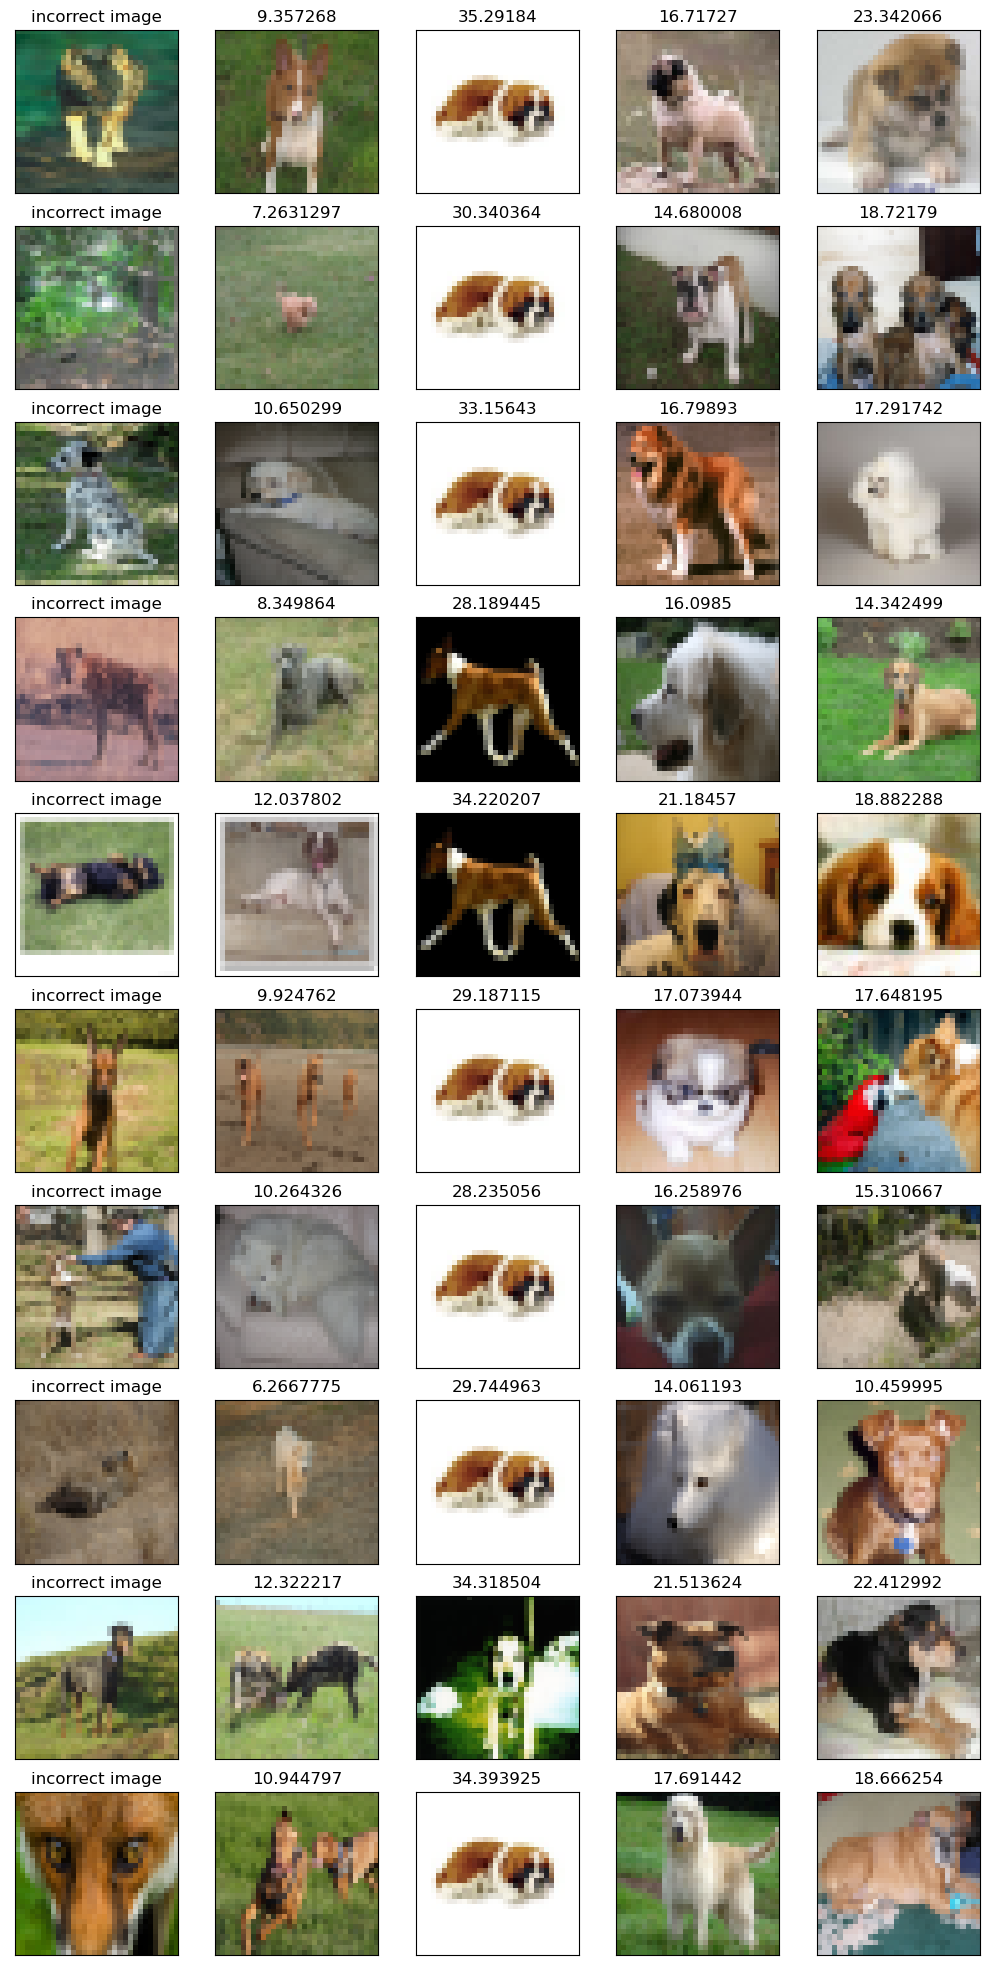

In [12]:
# Visualization
show_image_rows(
    images=image_rows,
    image_titles=label_rows)

In [14]:
# Save paths
save_edit_paths_dir = os.path.join('paths', 'edits', class_list[target_class])

    
# Save keys (incorrectly predicted)
save_keys_dir = os.path.join(save_edit_paths_dir, 'keys')
if not os.path.isdir(save_keys_dir):
    os.makedirs(save_keys_dir)
save_keys_path = os.path.join(save_keys_dir, 'key_image_paths.txt')
write_lists(save_keys_path, selected_incorrect_image_paths)
torch.save(selected_incorrect_images, os.path.join(save_keys_dir, 'key_images.pth'))

# Save values (correctly predicted)
save_values_dir = os.path.join(save_edit_paths_dir, 'values')
if not os.path.isdir(save_values_dir):
    os.makedirs(save_values_dir)
    
save_values_closest_path = os.path.join(save_values_dir, 'closest_values_image_paths.txt')
write_lists(save_values_closest_path, closest_correct_image_paths)
torch.save(closest_correct_images, os.path.join(save_values_dir, 'closest_value_images.pth'))

save_values_farthest_path = os.path.join(save_values_dir, 'farthest_values_image_paths.txt')
write_lists(save_values_farthest_path, farthest_correct_image_paths)
torch.save(farthest_correct_images, os.path.join(save_values_dir, 'farthest_value_images.pth'))

save_values_middle_path = os.path.join(save_values_dir, 'middle_values_image_paths.txt')
write_lists(save_values_middle_path, middle_correct_image_paths)
torch.save(middle_correct_images, os.path.join(save_values_dir, 'middle_value_images.pth'))

save_values_random_path = os.path.join(save_values_dir, 'random_values_image_paths.txt')
write_lists(save_values_random_path, random_correct_image_paths)
torch.save(random_correct_images, os.path.join(save_values_dir, 'random_value_images.pth'))

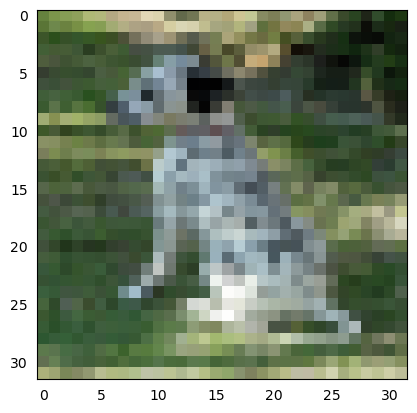

In [108]:
img = load_image('data/cinic-10-imagenet/train/dog/n02110341_7544.png')
show_image(img)